# Try to mimic the noise on the output of the LISA detector.

Following Maggiore chapter 7, Eqn. 7.x $<n(t)>=0$ and $< |\tilde n(f)|^2 > = \frac{1}{2} S_n(f) T $ and $S_n(f)$ is what we get from the Larson curve or other.  $T$ comes from the observation time, $[-T/2, T/2]$ so that the resolution is $\Delta f = \frac{1}{T}$, when thinking about discrete systems.  Units of $S_n(f)$ are per root Hz.

## Larson curve with arm length of 1e9 m, at url http://www.srl.caltech.edu/~shane/sensitivity/MakeCurve.html  , and this is the "Root Spectral Density, per root Hz" also called the Amplitude Spectral Density and is the square root of $S_n(f)$ .

In [1]:
# For this data file:
# SNR = 1.000000 
# Armlength = 1.000000e+09 	meters
# Optics diameter = 0.300000 	meters
# Wavelength = 1064.000000 	nanometers
# Laser power = 1.000000 Watts
# Optical train efficiency = 0.300000 
# Accleration noise = 3.000000e-15 m/(s^2 root Hz)
# Position noise = 2.000000e-11 m/(root Hz)
# Sensitivity Floor Set by Position Noise Budget
# Output Curve type is Root Spectral Density, per root Hz
# Astrophysical Noise is No White Dwarf Noise


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd

In [3]:
larsonData = np.loadtxt("scg_4728.dat", usecols=(0,1))

In [4]:
print(larsonData[0:3] )
print(larsonData[-5:-1])

[[  4.88251800e-07   1.64610800e-12]
 [  4.99628100e-07   1.57199900e-12]
 [  5.11269200e-07   1.50122800e-12]]
[[  5.12818500e+00   4.24026100e-18]
 [  5.14447900e+00   3.84136400e-18]
 [  5.16082500e+00   3.62256300e-18]
 [  5.17722000e+00   3.60446100e-18]]


In [5]:
print(  list(  map(len, [larsonData[:], larsonData[:,0], larsonData[:][1] ]) )  )

[900, 900, 2]


<IPython.core.display.Javascript object>


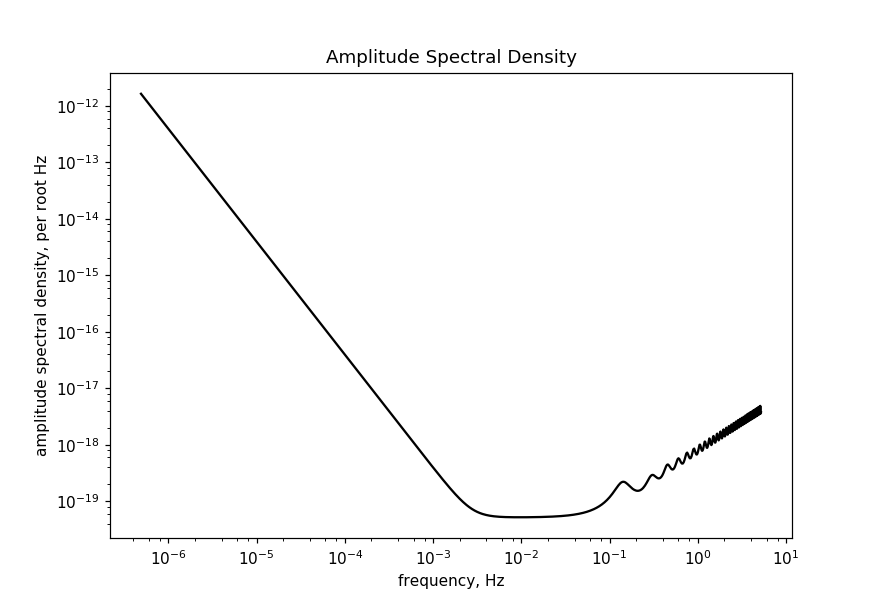

In [6]:
# Data from Larson curve generator as Amplitude Spectral Density.
fig = plt.figure(figsize=(8,5.5))
ax = plt.subplot((111))
ax.loglog(larsonData[:,0], larsonData[:,1], 'k-')
ax.set_title('Amplitude Spectral Density')
ax.set_xlabel('frequency, Hz')
ax.set_ylabel('amplitude spectral density, per root Hz')
plt.show()

<IPython.core.display.Javascript object>


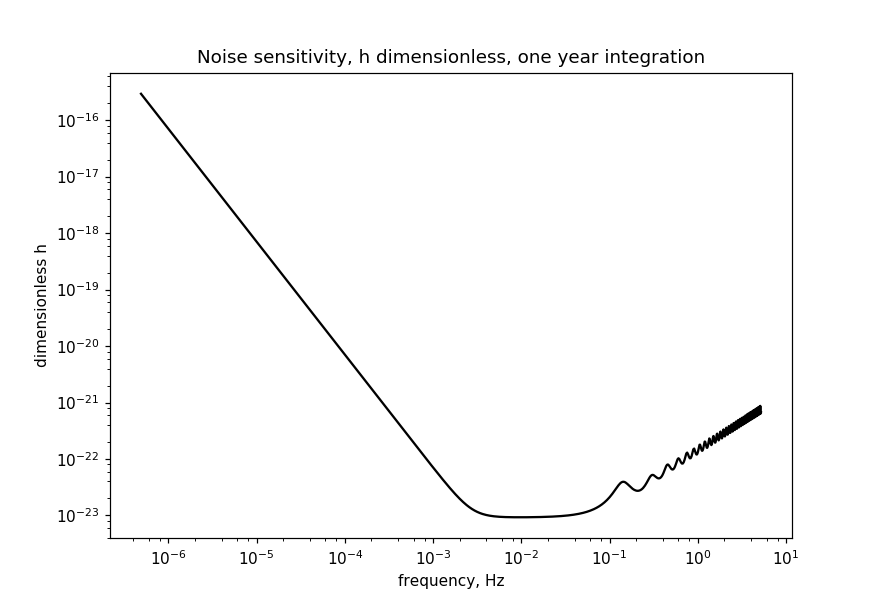

In [7]:
# Data as dimensionless h, ASD / root (time = 1 year) .
fig = plt.figure(figsize=(8,5.5))
ax = plt.subplot((111))
oneYear = 365.24*24.0*3600.;
ax.loglog(larsonData[:,0], larsonData[:,1]/np.sqrt(oneYear), 'k-')
ax.set_title('Noise sensitivity, h dimensionless, one year integration')
ax.set_xlabel('frequency, Hz')
ax.set_ylabel('dimensionless h')
plt.show()

<IPython.core.display.Javascript object>


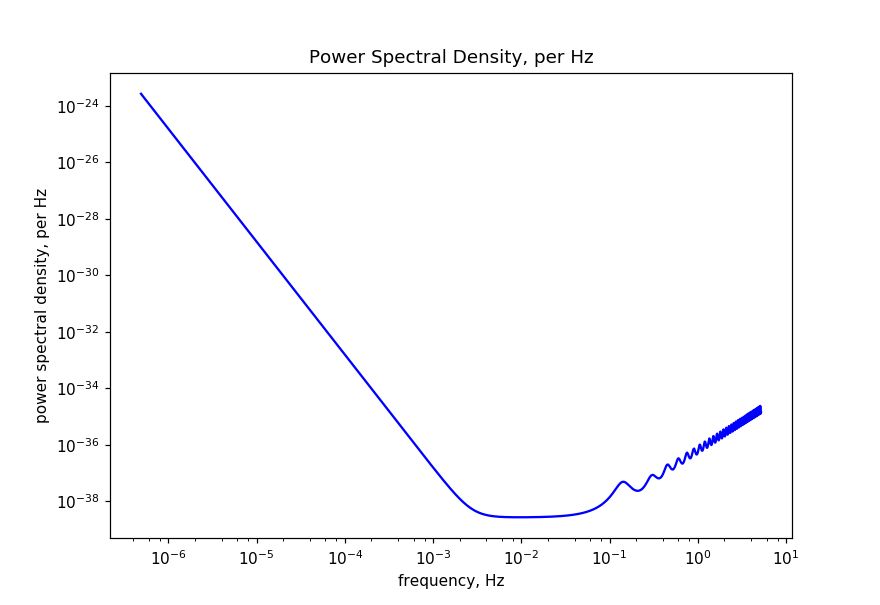

In [8]:
# Power spectral density as per Hz, square of ASD.
fig = plt.figure(figsize=(8,5.5))
ax = plt.subplot((111))
ax.loglog(larsonData[:,0], larsonData[:,1]**2, 'b-')
ax.set_title('Power Spectral Density, per Hz')
ax.set_xlabel('frequency, Hz')
ax.set_ylabel('power spectral density, per Hz')
plt.show()

Because the Exop frequency range is at max about 4e-4 Hz, work up to 1e-3 Hz and down to 1e-6 Hz, maybe.  
This sets the discretization that I use, a $T_{obs}$ a long observation time sets smallest $\Delta f=1/T_{obs}$ 
and the time discretization $\Delta t$ sets the highest frequency $f_{max}=1/$Delta t$ .

In [9]:
fmax = 1e-3; # in Hz
fmin = 1e-6; # in Hz
nres = 5; # number of points to resolve fmin, if you want 5 points in one fmin, use Tobs for fmin/5 .
Tobs = 1/fmin * nres; # in seconds
dt = 1/fmax;
tsize = int(Tobs/dt);
print('Using Tobs = %g and dt = %g for fmax = %g, fmin = %g, and nres = %d .'%(Tobs, dt, fmax, fmin, nres) )
print('Number of steps in an array of n(t) is Tobs/df = %g .'%( (Tobs/dt) )   )

Using Tobs = 5e+06 and dt = 1000 for fmax = 0.001, fmin = 1e-06, and nres = 5 .
Number of steps in an array of n(t) is Tobs/df = 5000 .


<IPython.core.display.Javascript object>


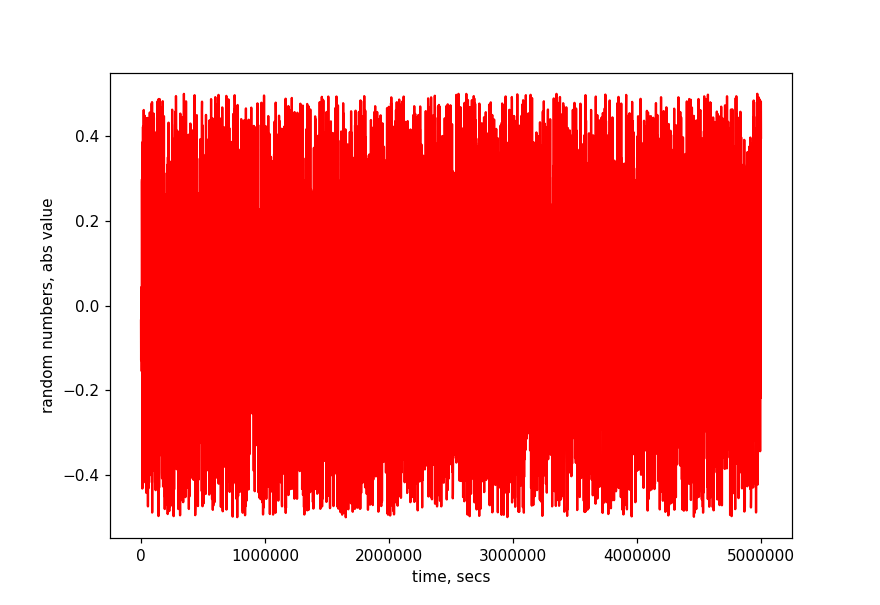

5000 5000
noft[0:3]  [-0.03551643 -0.12903864 -0.05301984]
From previous iteration  [0.08543612, 0.2262698, -0.05144637]


In [10]:
## Try the usual random number generator as a simple function of time.
fig = plt.figure(figsize=(8,5.5))
ax = plt.subplot((111))
noft = np.random.rand(tsize)-0.5  # np.random.rand(tsize) delivers np array with flat distribution 0 to 1.
time = np.arange(dt,Tobs+dt,dt)
print(len(noft), len(time))
ax.plot(time, noft, 'r-')
ax.set_xlabel('time, secs')
ax.set_ylabel('random numbers, abs value')
plt.show()
print("noft[0:3] " ,noft[0:3])
print("From previous iteration ", [ 0.08543612,  0.2262698,  -0.05144637] )

## Do some real FFTs.

Length of freqs and yoff 2501 2501
[  0.00000000e+00   2.00000000e-07   4.00000000e-07]
[-0.30081235+0.j          0.09936629-0.0070124j   0.39652522-0.33032946j]
[ 0.30081235  0.09961342  0.51609088]


<IPython.core.display.Javascript object>


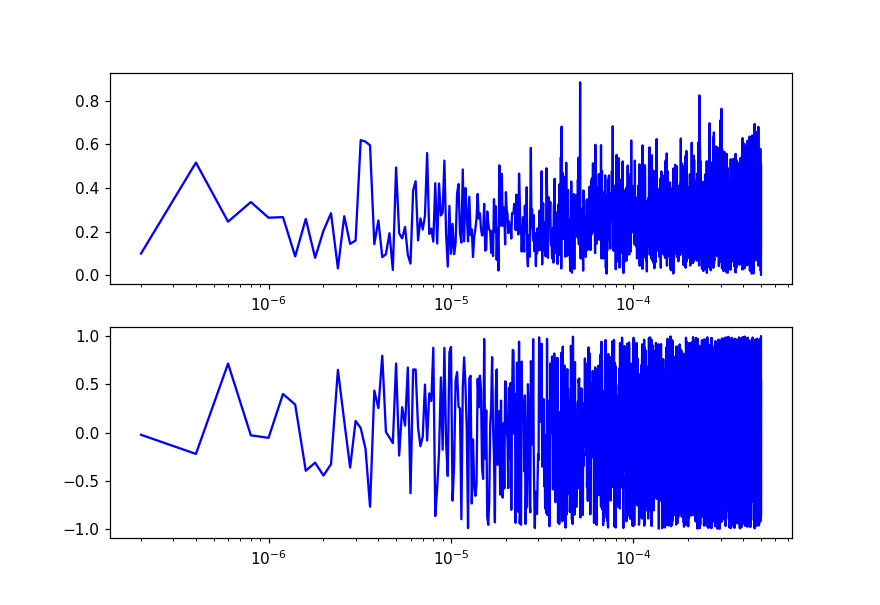

In [15]:
yoft = noft  # Should have a zero average.
num = len(yoft)
freqs = np.fft.rfftfreq( num, dt )
# From GW170817 LIGO analysis example:
# whitening: transform to freq domain, divide by asd, then transform back, 
# taking care to get normalization right.
yoff = np.fft.rfft( yoft, norm = 'ortho' )  # Looks like ortho does ampl/sqrt(2N) or so.
print('Length of freqs and yoff', len(freqs), len(yoff))
print(freqs[0:3])
print(yoff[0:3])
print(np.abs( yoff[0:3] ) )
#
fig = plt.figure(figsize=(8,5.5) )
ax = fig.add_subplot(211)
ax.semilogx(freqs[:], np.abs(yoff[:]), 'b-')  # Skip the strong DC component.
ax = fig.add_subplot(212)
ax.semilogx(freqs[:], np.angle(yoff[:])/np.pi, 'b-')  # Skip the strong DC component.
plt.show()

In [12]:
aa = np.complex(1.414, 1.414)
print(np.abs(aa))
print(np.angle(aa))  # Angle is radians by default.
print(np.angle(aa, deg=True))

1.9996979772
0.785398163397
45.0


## MLab power spectral density function again from GW170817 LIGO example.

In [13]:
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

import matplotlib.mlab as mlab
import h5py

Length of Pxx_noft is  2501
freqs from mlab.psd 0 element  0.0  and last one  0.0005
Interpolator of psd_noft at 1e-6, 1e-5, 1e-4  36.343755897849405 21.089475535595145 246.07675305378893


<IPython.core.display.Javascript object>


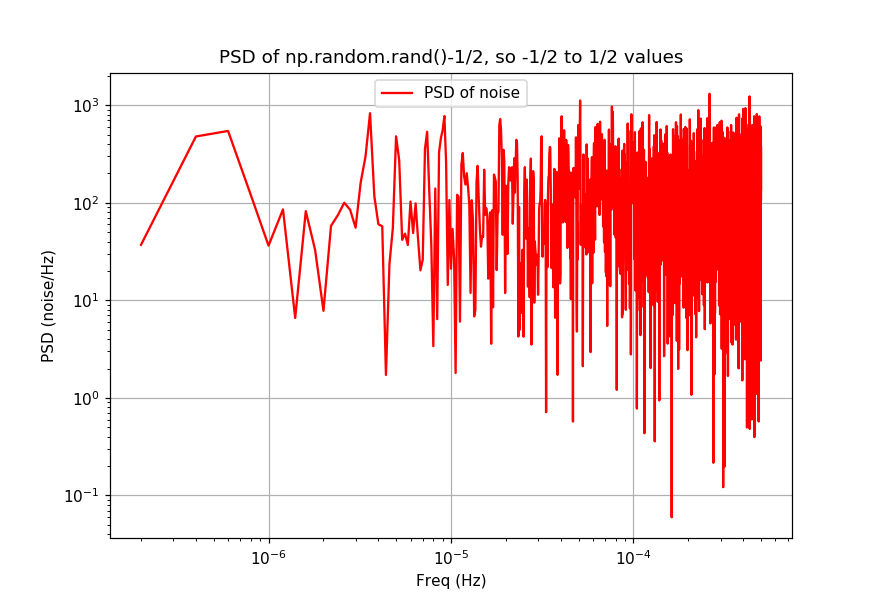

In [16]:
# number of sample for the fast fourier transform:
NFFT = 1*len(noft)
fminPlot = 1e-7
fmaxPlot = 1e-3
Pxx_noft, freqs = mlab.psd(noft, Fs = 1.0/dt, NFFT = NFFT) 
print('Length of Pxx_noft is ', len(Pxx_noft) )
print('freqs from mlab.psd 0 element ', freqs[0], ' and last one ', freqs[-1])
# mlab is matplotlib.mlab, same function names as Matlab
# https://matplotlib.org/api/mlab_api.html#matplotlib.mlab.psd

# We will use interpolations of the ASDs computed above for whitening:
psd_noft = interp1d(freqs, Pxx_noft)
print('Interpolator of psd_noft at 1e-6, 1e-5, 1e-4 ', psd_noft(1e-6), psd_noft(1e-5), psd_noft(1e-4) )

# plot the PSDs:
fig = plt.figure(figsize=(8,5.5))
ax = fig.add_subplot((111))
ax.loglog(freqs, Pxx_noft,'r',label='PSD of noise')
#ax.axis([fmin, fmax, 1e-24, 1e-19])
ax.grid('on')
ax.set_ylabel('PSD (noise/Hz)')
ax.set_xlabel('Freq (Hz)')
ax.legend(loc='upper center')
ax.set_title('PSD of np.random.rand()-1/2, so -1/2 to 1/2 values')
#plt.savefig('GW170817_ASDs.png')
plt.show()